In [1]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import random
import networkx as nx
import math
from scipy import stats
import pickle
import community
import copy
import math
import matplotlib.animation as animation
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage, fclusterdata
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import time
from IPython.display import clear_output
import datetime
from scipy.spatial.distance import pdist, squareform

In [2]:
from matplotlib import animation, rc
from IPython.display import HTML

In [45]:
coop_matrix = np.array([[1,0.5,0.3],[0.4,1,0.7],[0.4,0.6,1]])
A = [np.mean(np.array([coop_matrix[n][i] for n in range(3) if n!=i])) for i in range(3)]
print (np.arctan(A))

[0.38050638 0.50284321 0.46364761]


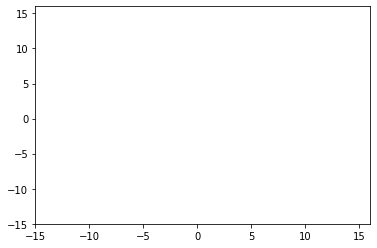

In [3]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-15, 16), ylim=(-15, 16))
particles_d, = ax.plot([], [], 'bo', ms=4)
particles_c, = ax.plot([], [], 'ro', ms=2)
#parents, = ax.plot([], [], 'ro', ms=4)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# initialization function: plot the background of each frame
def init():
    particles_c.set_data([], [])
    particles_d.set_data([], [])
    #parents.set_data([], [])
    time_text.set_text('')
    return particles_c,particles_d,time_text

# animation function.  This is called sequentially
def animate(i):
    global locs,loc_c,loc_d
    x_c = [z[0] for z in loc_c[i]]
    y_c = [z[1] for z in loc_c[i]]
    particles_c.set_data(x_c,y_c)
    x_d = [z[0] for z in loc_d[i]]
    y_d = [z[1] for z in loc_d[i]]
    particles_d.set_data(x_d,y_d)
    time_text.set_text('Time = %.1f' % i)
    return particles_c,particles_d, time_text

In [4]:
def dot_product_coordinates(pos,coeffs):
    z = np.array([pos[i]*coeffs[i] for i in range(np.size(coeffs))])
    return np.sum(z,axis=0)

def transform_clusters(clusters):
    d = dict()
    for e in np.unique(clusters):
        d[e] = [i for i,j in enumerate(clusters) if j==e]
    return d

In [5]:
a_ij=[0.90576145]
p=np.array([[ 0.35217129, -0.33455179]])
dot_product_coordinates(p, a_ij)

array([ 0.31898318, -0.30302411])

In [6]:
def discrete_step_number(x):
    return 1 if x>=0 else -1

def discrete_step(ar):
    return np.where(ar>=0,1,-1)

def dist_arr(pos,ar):
    dist = lambda p1,p2: math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
    return np.array([dist(pos,ar[i]) for i in range(np.size(ar,0))])

In [7]:
pos = [0,0]
a = np.array([[1,1],[2,2],[3,3]])
dist = lambda p1,p2: math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
print (dist_arr(pos,a))
1/(1+dist_arr(pos,a))**2

[1.41421356 2.82842712 4.24264069]


array([0.17157288, 0.06822746, 0.03638311])

In [8]:
def sec_to_string(seconds) :
    return str(datetime.timedelta(seconds=seconds))

class progress_bar:
    
    def __init__(self,n_max):
        self.n_max = n_max
    
    def update_progress(self,progress):
        bar_length = self.n_max
        if isinstance(progress, int):
            progress = float(progress)
        if not isinstance(progress, float):
            progress = 0
        if progress < 0:
            progress = 0
        if progress >= 1:
            progress = 1
        return progress
            
    def display(self, progress):
        progress = self.update_progress(progress)
        block = int(round(self.n_max * progress))
        clear_output(wait = True)
        text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (self.n_max - block), progress * 100)
        print(text)

In [9]:
class roulette_wheel(object):
    
    def __init__(self,pop):
        self.pop = pop
        self.pop_fitness = self.pop_fitness()
        self.probabilities = self.get_probability_list()
    
    def pop_fitness(self):
        pop_fitness = dict()
        for n in range(len(self.pop)):
            pop_fitness[n] = self.pop.payoffs[n]
        return pop_fitness
        
    def get_probability_list(self):
        fitness = self.pop_fitness.values()
        total_fit = sum(fitness)
        relative_fitness = [f/total_fit for f in fitness]
        probabilities = [sum(relative_fitness[:i+1]) for i in range(len(relative_fitness))]
        return probabilities


    def roulette_wheel_pop(self):
        chosen = []
        for n in range(len(self.pop)):
            r = random.random()
            for i in range(len(self.pop)):
                if r <= self.probabilities[i]:
                    chosen.append(i)
                    break
        return chosen

In [10]:
class pop:
    
    def __init__(self, n_res, p_coop, q, n_mut, beta, gamma, alpha):
        self.n_resident = n_res
        self.p_coop = p_coop
        self.q = q
        self.n_mutants = n_mut
        self.beta = beta
        self.gamma = gamma
        self.alpha = alpha
        
    def __len__(self):
        return self.n_resident + self.n_mutants

    def init_players_resident(self,p_coop = 1, clustering = False, n_clusters = 4):
        self.p_sharing = np.array([self.p_coop for i in range(self.n_resident)])
        if clustering:
            p = q = []
            for n in range(self.n_resident):
                m = n%n_clusters
                if m==0:
                    x,y = 0.1+np.random.uniform(-0.05,0.05), 0.1+np.random.uniform(-0.05,0.05)
                elif m==1:
                    x,y = 0.9+np.random.uniform(-0.05,0.05), 0.1+np.random.uniform(-0.05,0.05)
                elif m==2:
                    x,y = 0.9+np.random.uniform(-0.05,0.05), 0.9+np.random.uniform(-0.05,0.05)
                else:
                    x,y = 0.1+np.random.uniform(-0.05,0.05), 0.9+np.random.uniform(-0.05,0.05)
                p.append(x)
                q.append(y)
            self.pos = np.array(list(zip(p,q)))
        else:
            x,y = np.random.uniform(0,1,self.n_resident), np.random.uniform(0,1,self.n_resident)
            self.pos = np.array(list(zip(x,y)))
            
    def add_mutants(self, locs=None):
        q_sharing = np.array([self.q for i in range(self.n_mutants)])
        self.p_sharing = np.append(self.p_sharing, q_sharing)
        if locs==None:
            x,y = np.random.uniform(0,1,self.n_mutants), np.random.uniform(0,1,self.n_mutants)
            self.pos = np.concatenate((self.pos,np.array(list(zip(x,y)))))
        else:
            for loc in locs:
                self.pos = np.concatenate(self.pos,loc)
            
    def create_game_matrix(self):
        """Create a matrix of strategies"""
        beta = self.beta
        dm = np.exp(squareform(pdist(self.pos))*(math.log(beta)/math.sqrt(2)))
        self.dm = dm
        gm = (dm.T * self.p_sharing).T
        np.fill_diagonal(gm, 0)
        self.current_coop = gm
        self.coop_matrix = gm
        
    def update_pos(self, v_max = 1, eta = 0.01, normalise = True):
        old_pos = self.pos
        self.pos = []
        moves = np.asarray([[(p2-p1)/np.linalg.norm(p2-p1) for p2 in old_pos] for p1 in old_pos])
        for i in range(self.n_resident + self.n_mutants):
            neighbors = np.asarray([int(j) for j in range(self.n_resident + self.n_mutants) if j!=i])
            weights_neighbours = self.dm[i,neighbors]
            div = self.p_sharing[neighbors] - self.p_sharing[i]
            #div = self.coop_matrix[neighbors,i] - self.coop_matrix[i,neighbors]
            sgn = discrete_step(div)
            #print (sgn)
            func_form = (1+abs(div))**self.alpha
            #print (old_pos)
            decay_dist = 1/(1+dist_arr(old_pos[i],old_pos[neighbors]))**self.gamma
            weights = sgn*func_form
            w_ij = weights*decay_dist
            #print ('w_ij',w_ij)
            a_ij = w_ij/np.sum(np.absolute(w_ij))
            a_ij = a_ij*v_max
            #print ('v_max',v_max)
            #print ('a_ij',a_ij)
            pm = moves[i,neighbors]
            #print ('pm',pm)
            #print (dot_product_coordinates(pm,a_ij))
            d_p = dot_product_coordinates(pm,a_ij) + np.random.uniform(-eta,eta,2)
            #print ('d_p',d_p)
            if normalise:
                d_p = d_p/(np.linalg.norm(d_p))
            self.pos.append(old_pos[i] + d_p)
        #print (self.pos)
        self.pos = np.asarray(self.pos)
            
    def pay_off(self):
        average_sharing = [np.mean(np.array([self.coop_matrix[n][i] for n in range(len(self)) if n!=i])) for i in range(len(self))]
        self.payoffs = np.arctan(average_sharing)
        
    def selection(self):
        RL = roulette_wheel(self)
        self.parents = RL.roulette_wheel_pop()
        
    def reproduction(self, mutation_sharing = False):
        self.p_sharing = self.p_sharing[np.asarray(self.parents)]
        if mutation_sharing:
            self.p_sharing = self.p_sharing + np.random.normal(0,0.01,len(self))
        pos = np.array([self.pos[i] for i in self.parents])
        self.pos = pos + np.random.normal(0,0.01,(len(self),2))
        self.create_game_matrix()
        self.pay_off()
        
    def silloutte_k_means(self):
        """Perform the silloutte k-means clustering analysis"""
        range_n_clusters = range(2,12)
        #X = self.get_locations_all_list()
        X = self.pos
        silhouettes = np.empty(0)
        clusterers=[]
        for n_clusters in range_n_clusters:
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            clusterers.append(clusterer)
            cluster_labels = clusterer.fit_predict(X)
            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouettes = np.append(silhouettes, silhouette_avg)
        k_best = np.argmax(silhouettes)
        clusterer = clusterers[k_best]
        kmeans = clusterer.fit(X)
        labels = kmeans.labels_
        clusters = transform_clusters(labels)
        info_sharing_clusters = []
        for key,value in clusters.items():
            if len(value)==0:
                assert ValueError ('An empty cluster found')
            elif len(value)==1:
                info_sharing_clusters.append(self.p_sharing[value[0]])
            else:
                info_sharing_clusters.append(np.mean(np.array([self.coop_matrix[i][j] for i in value for j in value if i!=j])))
        unique_elements, counts_elements = np.unique(labels, return_counts=True)
        return np.size(unique_elements), np.max(counts_elements), counts_elements, info_sharing_clusters, labels
    
    def get_locations_p(self):
        loc = [self.pos[n] for n in range(len(self)) if self.p_sharing[n]>self.q]
        return loc
    
    def get_locations_q(self):
        loc = [self.pos[n] for n in range(len(self)) if self.p_sharing[n]<=self.q]
        return loc

In [11]:
class Sim_mutant_resident:
    
    def __init__(self, n_iter, n_res, p_coop, q, n_mut, beta, gamma=2, alpha = 2, normalise = True, clustering = False):
        self.n_iter = n_iter
        self.population = self.init_pop(n_res, p_coop, q, n_mut, beta, gamma, alpha, clustering)
        self.normalise = normalise
        
    def init_pop(self, n_res, p_coop, q, n_mut, beta, gamma, alpha, clustering = False):
        population = pop(n_res, p_coop, q, n_mut, beta, gamma, alpha)
        population.init_players_resident(p_coop, clustering)
        population.add_mutants()
        population.create_game_matrix()
        return population
    
    def loop_pos(self, selection = False, steps = 20, v_max = 0.5, eta = 0.01):
        start = int(round(time.time()))
        loc_p=dict()
        loc_q=dict()
        bar = progress_bar(self.n_iter)
        for t in range(self.n_iter):
            loc_p[t] = self.population.get_locations_p()
            loc_q[t] = self.population.get_locations_q()
            self.population.update_pos(v_max, eta,self.normalise)
            if selection:
                self.population.pay_off()
                if t % steps == 0:
                    self.population.selection()
                    self.population.reproduction()
            bar.display((t+1)/self.n_iter)
        print ('Duration:',sec_to_string(int(round(time.time())) - start))
        return loc_p, loc_q
    
    def loop(self, selection = False, steps = 20, mutation_sharing = False, v_max = 0.5, eta = 0.01):
        start = int(round(time.time()))
        loc_p=dict()
        loc_q=dict()
        n_clusters=[]
        max_cluster=[]
        size_clusters=[]
        info_sharing_clusters=[]
        bar = progress_bar(self.n_iter)
        for t in range(self.n_iter):
            loc_p[t] = self.population.get_locations_p()
            loc_q[t] = self.population.get_locations_q()
            n_clusters.append(self.population.silloutte_k_means()[0])
            max_cluster.append(self.population.silloutte_k_means()[1])
            size_clusters.append(self.population.silloutte_k_means()[2])
            info_sharing_clusters.append(self.population.silloutte_k_means()[3])
            self.population.update_pos(v_max,eta,self.normalise)
            if selection:
                self.population.pay_off()
                if t % steps == 0:
                    self.population.selection()
                    self.population.reproduction(mutation_sharing)
            bar.display((t+1)/self.n_iter)
        print ('Duration:',sec_to_string(int(round(time.time())) - start))
        return loc_p, loc_q, n_clusters, max_cluster, size_clusters, info_sharing_clusters
    
    def plot_results(self, selection=False, steps = 20, mutation_sharing = False, v_max = 0.5, eta = 0.01):
        loc_p, loc_q, n_clusters, max_cluster, size_clusters, info_sharing_clusters = self.loop(selection, steps, mutation_sharing, v_max, eta)
        clusters = np.array([list(i) for i in size_clusters])
        sharing = np.array([i for i in info_sharing_clusters])
        t = [i for i in range(1,self.n_iter+1)]
        
        fig = plt.figure(figsize=(10,12))
        
        plt.subplot(4, 2, 1)
        plt.plot(t,n_clusters)
        plt.title('Number of clusters')
        
        plt.subplot(4, 2, 2)
        plt.plot(t,max_cluster)
        plt.title('Size of the largest cluster')
        
        plt.subplot(4,2,3)
        for k in t:
            plt.scatter([k for i in range(len(clusters[k-1]))],clusters[k-1], marker='o', s=2, color='k')
        plt.title('Evolution of cluster sizes')
        
        plt.subplot(4,2,4)
        for k in t:
            plt.scatter([k for i in range(len(sharing[k-1]))],sharing[k-1], marker='o', s=2, color='k')
        plt.title('Evolution of sharing rates in within clusters')
        
        fig.tight_layout()
        plt.show()                     
        
        return loc_p, loc_q
    

# Simulations

Consider a population of $N$ residents and introduce $K$ mutants. Residents and mutants are placed uniformely in $[0,1]$. All residents have the same strategy $s(i)=p,  \forall i \in N$ and $s(j)=q,  \forall j \in K$, where $q<p$. The tunable parameters are:
- p 
- q 
- $\beta$, 'the radius of interaction', where $s(i) . \beta$ is the propensity to share information in the case two points are furthest away possible in the initial configuration
- relative speed of movement and reproduction + mutation, i.e. the number of time steps after which reproduction + mutation occur

## No selection and reproduction

- 2 residents (p=0.7), 1 mutant (q=0.5)
- $\alpha=4$
- $\beta=0.99$
- $\gamma=0.25$
- normalise vector d: False

In [12]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 2, p_coop = 0.7, q = 0.5, n_mut = 1, beta=0.99, gamma = 1/4, alpha = 4, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


In [13]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 2, p_coop = 0.7, q = 0.5, n_mut = 1, beta=0.99, gamma = 1/4, alpha = 4, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


In [14]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 2, p_coop = 0.7, q = 0.5, n_mut = 1, beta=0.99, gamma = 1/4, alpha = 4, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=100, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


- 2 residents (p=0.7), 1 mutant (q=0.5)
- $\alpha=1/2$
- $\beta=0.99$
- $\gamma=2$
- normalise vector d: False

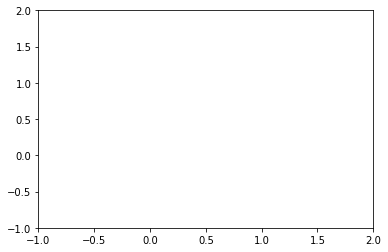

In [15]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-1, 2), ylim=(-1, 2))
particles_d, = ax.plot([], [], 'bo', ms=4)
particles_c, = ax.plot([], [], 'ro', ms=2)
#parents, = ax.plot([], [], 'ro', ms=4)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# initialization function: plot the background of each frame
def init():
    particles_c.set_data([], [])
    particles_d.set_data([], [])
    #parents.set_data([], [])
    time_text.set_text('')
    return particles_c,particles_d,time_text

# animation function.  This is called sequentially
def animate(i):
    global locs,loc_c,loc_d
    x_c = [z[0] for z in loc_c[i]]
    y_c = [z[1] for z in loc_c[i]]
    particles_c.set_data(x_c,y_c)
    x_d = [z[0] for z in loc_d[i]]
    y_d = [z[1] for z in loc_d[i]]
    particles_d.set_data(x_d,y_d)
    time_text.set_text('Time = %.1f' % i)
    return particles_c,particles_d, time_text

In [16]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 2, p_coop = 0.7, q = 0.5, n_mut = 1, beta=0.99, gamma = 2, alpha = 1/2, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


In [17]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 2, p_coop = 0.7, q = 0.5, n_mut = 1, beta=0.99, gamma = 2, alpha = 1/2, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


- 2 residents (p=0.7), 1 mutant (q=0.5)
- $\alpha=1/2$
- $\beta=0.99$
- $\gamma=8$
- normalise vector d: False

In [18]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 2, p_coop = 0.7, q = 0.5, n_mut = 1, beta=0.99, gamma = 8, alpha = 1/2, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


- 2 residents (p=0.7), 1 mutant (q=0.5)
- $\alpha=4$
- $\beta=0.99$
- $\gamma=4$
- normalise vector d: False

In [19]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 2, p_coop = 0.7, q = 0.5, n_mut = 1, beta=0.99, gamma = 4, alpha = 4, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


- 2 residents (p=0.7), 1 mutant (q=0.5)
- $\alpha=4$
- $\beta=0.99$
- $\gamma=2$
- normalise vector d: False

In [20]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 2, p_coop = 0.7, q = 0.5, n_mut = 1, beta=0.99, gamma = 2, alpha = 4, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


- 10 residents (p=0.7), 1 mutant (q=0.69)
- $\alpha=8$
- $\beta=0.99$
- $\gamma=0.25$
- normalise vector d: False

In [21]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 10, p_coop = 0.7, q = 0.69, n_mut = 1, beta=0.99, gamma = 0.25, alpha = 8, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:01


- 10 residents (p=0.7), 1 mutant (q=0.69)
- $\alpha=1/2$
- $\beta=0.99$
- $\gamma=4$
- normalise vector d: False

In [22]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 10, p_coop = 0.7, q = 0.69, n_mut = 1, beta=0.99, gamma = 4, alpha = 1/2, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


- 10 residents (p=0.7), 1 mutant (q=0.3)
- $\alpha=1/2$
- $\beta=0.99$
- $\gamma=4$
- normalise vector d: False

In [23]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 10, p_coop = 0.7, q = 0.3, n_mut = 1, beta=0.99, gamma = 4, alpha = 4, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


- 10 residents (p=0.7), 1 mutant (q=0.3)
- $\alpha=20$
- $\beta=0.99$
- $\gamma=0.25$
- normalise vector d: False

In [24]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 10, p_coop = 0.7, q = 0.59, n_mut = 1, beta=0.99, gamma = 0.25, alpha = 20, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:00


In [25]:
coeffs = np.array([0.06224283, 0.05782395,  0.05797724,  0.06180964,  0.06311181,  0.05930722,
0.05888618,  0.06648056,  0.0625458,  -0.44981479])
pos = np.array([np.array([-0.47824739,  0.02844751]),
 np.array([-0.67951285, -0.71409953]),
 np.array([-0.75429105, -0.60159846]),
 np.array([-0.03993988, -0.51946225]),
 np.array([-0.20279542, -0.34396631]),
 np.array([ 0.20588858, -0.76726937]),
 np.array([-0.58942501, -0.60727235]),
 np.array([-0.12268356,  0.05986909]),
 np.array([-0.0889906, -0.44176708]),
 np.array([ 0.05605516, -0.7408551 ])])
z = np.array([pos[i]*coeffs[i] for i in range(np.size(coeffs))])
print (z)
np.sum(z,axis=0)

[[-0.02976747  0.00177065]
 [-0.03929212 -0.04129206]
 [-0.04373171 -0.03487902]
 [-0.00246867 -0.03210777]
 [-0.01279879 -0.02170834]
 [ 0.01221068 -0.04550461]
 [-0.03470899 -0.03575995]
 [-0.00815607  0.00398013]
 [-0.00556599 -0.02763068]
 [-0.02521444  0.33324758]]


array([-0.18949356,  0.10011594])

- 100 residents (p=0.7), 1 mutant (q=0.3)
- $\alpha=4$
- $\beta=0.99$
- $\gamma=0.25$
- normalise vector d: False

In [26]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 100, p_coop = 0.7, q = 0.59, n_mut = 1, beta=0.99, gamma = 2, alpha = 20, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:13


- 100 residents (p=0.7), 1 mutant (q=0)
- $\alpha=4$
- $\beta=0.99$
- $\gamma=2$
- normalise vector d: False

In [27]:
sim = Sim_mutant_resident(n_iter = 50, n_res = 100, p_coop = 0.7, q = 0, n_mut = 10, beta=0.99, gamma = 2, alpha = 4, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [##################################################] 100.0%
Duration: 0:00:15


- 200 residents (p=0.7), 10 mutant (q=0)
- $\alpha=6$
- $\beta=0.99$
- $\gamma=2$
- normalise vector d: False

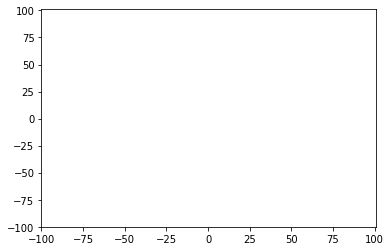

In [28]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-100, 101), ylim=(-100, 101))
particles_d, = ax.plot([], [], 'bo', ms=4)
particles_c, = ax.plot([], [], 'ro', ms=2)
#parents, = ax.plot([], [], 'ro', ms=4)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# initialization function: plot the background of each frame
def init():
    particles_c.set_data([], [])
    particles_d.set_data([], [])
    #parents.set_data([], [])
    time_text.set_text('')
    return particles_c,particles_d,time_text

# animation function.  This is called sequentially
def animate(i):
    global locs,loc_c,loc_d
    x_c = [z[0] for z in loc_c[i]]
    y_c = [z[1] for z in loc_c[i]]
    particles_c.set_data(x_c,y_c)
    x_d = [z[0] for z in loc_d[i]]
    y_d = [z[1] for z in loc_d[i]]
    particles_d.set_data(x_d,y_d)
    time_text.set_text('Time = %.1f' % i)
    return particles_c,particles_d, time_text

In [29]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0, n_mut = 10, beta=0.99, gamma = 2, alpha = 6, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [####################################################################################################] 100.0%
Duration: 0:01:39


- 200 residents (p=0.7), 10 mutant (q=0)
- $\alpha=6$
- $\beta=0.99$
- $\gamma=2$
- normalise vector d: True

In [30]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0, n_mut = 10, beta=0.99, gamma = 2, alpha = 6, normalise = True)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [####################################################################################################] 100.0%
Duration: 0:01:39


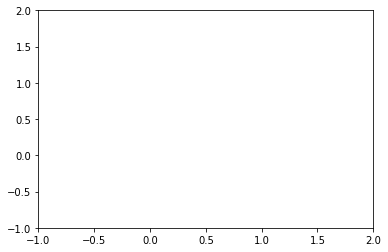

In [31]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-1, 2), ylim=(-1, 2))
particles_d, = ax.plot([], [], 'bo', ms=4)
particles_c, = ax.plot([], [], 'ro', ms=2)
#parents, = ax.plot([], [], 'ro', ms=4)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# initialization function: plot the background of each frame
def init():
    particles_c.set_data([], [])
    particles_d.set_data([], [])
    #parents.set_data([], [])
    time_text.set_text('')
    return particles_c,particles_d,time_text

# animation function.  This is called sequentially
def animate(i):
    global locs,loc_c,loc_d
    x_c = [z[0] for z in loc_c[i]]
    y_c = [z[1] for z in loc_c[i]]
    particles_c.set_data(x_c,y_c)
    x_d = [z[0] for z in loc_d[i]]
    y_d = [z[1] for z in loc_d[i]]
    particles_d.set_data(x_d,y_d)
    time_text.set_text('Time = %.1f' % i)
    return particles_c,particles_d, time_text

In [32]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0.6, n_mut = 10, beta=0.99, gamma = 2, alpha = 6, normalise = True)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [####################################################################################################] 100.0%
Duration: 0:01:38


In [33]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0.6, n_mut = 10, beta=0.99, gamma = 100, alpha = 1/2, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [####################################################################################################] 100.0%
Duration: 0:01:39


In [34]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0.6, n_mut = 10, beta=0.99, gamma = 100, alpha = 100, normalise = False)
loc_c, loc_d = sim.loop_pos()

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [####################################################################################################] 100.0%
Duration: 0:01:39


# With selection, reproduction and mutation

## No mutation in individual strategies p

Progress: [####################################################################################################] 100.0%
Duration: 0:06:46


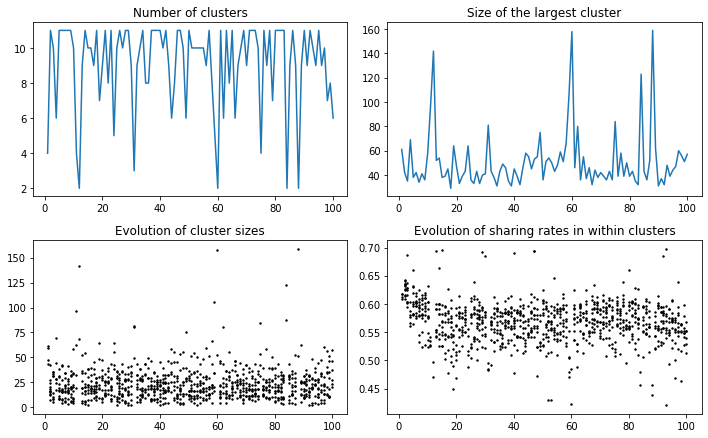

In [35]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0.6, n_mut = 10, beta=0.5, gamma = 50, alpha = 50, normalise = False)
loc_c, loc_d = sim.plot_results(selection = True, steps = 1)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [####################################################################################################] 100.0%
Duration: 0:07:43


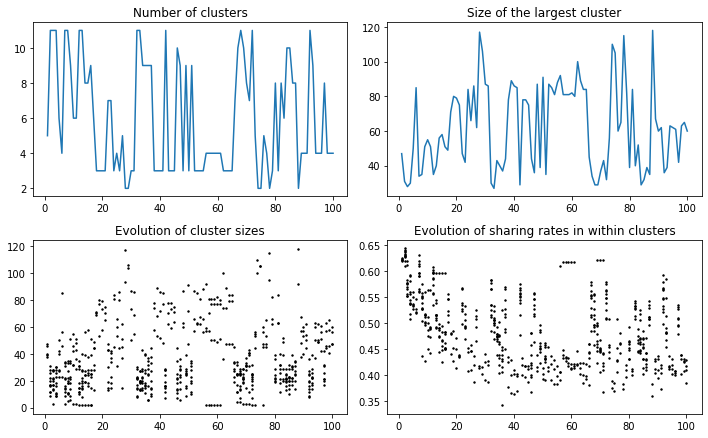

In [36]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0.6, n_mut = 10, beta=0.5, gamma = 50, alpha = 50, normalise = False)
loc_c, loc_d = sim.plot_results(selection = True, steps = 5)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [####################################################################################################] 100.0%
Duration: 0:06:39


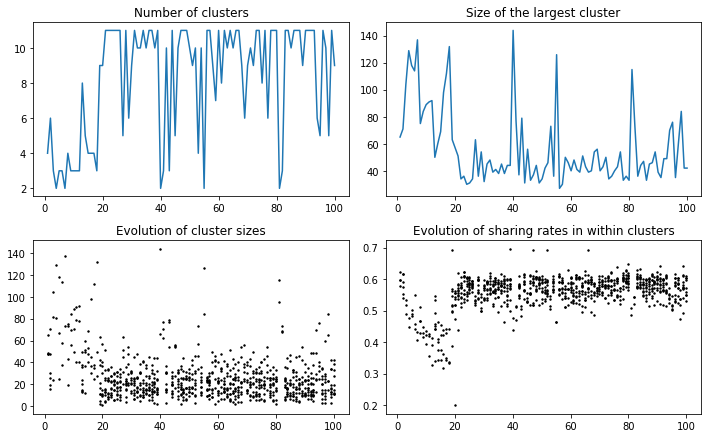

In [37]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0.2, n_mut = 10, beta=0.5, gamma = 50, alpha = 50, normalise = False)
loc_c, loc_d = sim.plot_results(selection = True, steps = 1)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [####################################################################################################] 100.0%
Duration: 0:06:42


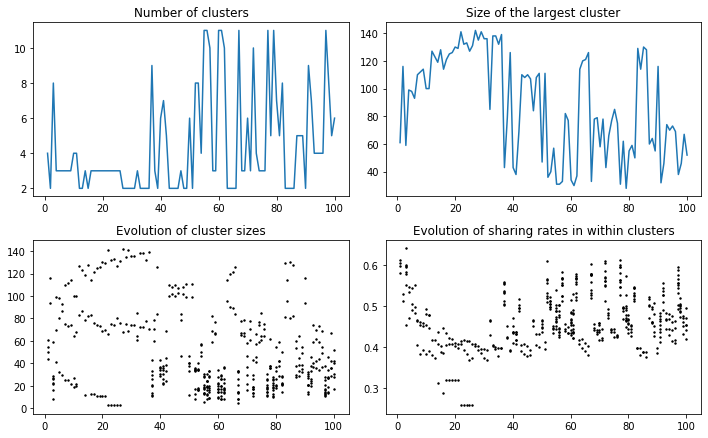

In [38]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0.2, n_mut = 10, beta=0.5, gamma = 50, alpha = 50, normalise = False)
loc_c, loc_d = sim.plot_results(selection = True, steps = 5)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

## Small mutation in individual strategies p

Progress: [####################################################################################################] 100.0%
Duration: 0:06:30


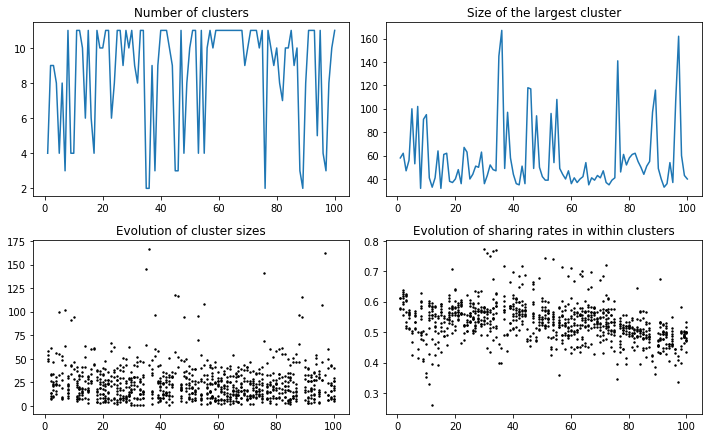

In [39]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0.2, n_mut = 10, beta=0.5, gamma = 50, alpha = 50, normalise = False)
loc_c, loc_d = sim.plot_results(selection = True, steps = 1, mutation_sharing = True)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

Progress: [####################################################################################################] 100.0%
Duration: 0:06:32


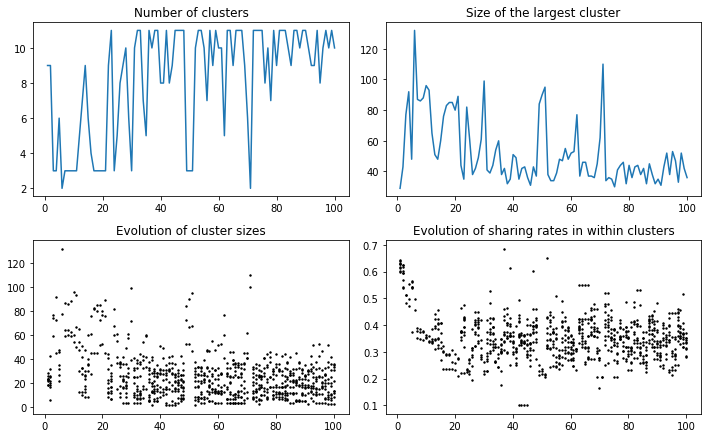

In [40]:
sim = Sim_mutant_resident(n_iter = 100, n_res = 200, p_coop = 0.7, q = 0.2, n_mut = 10, beta=0.5, gamma = 50, alpha = 50, normalise = False)
loc_c, loc_d = sim.plot_results(selection = True, steps = 5, mutation_sharing = True)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=300, blit=True)
rc('animation', html='html5')
anim

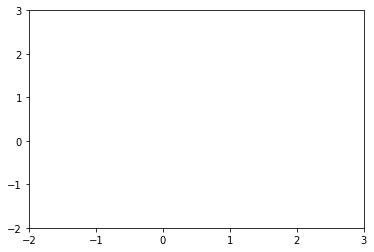

In [41]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-2, 3), ylim=(-2, 3))
particles_d, = ax.plot([], [], 'bo', ms=4)
particles_c, = ax.plot([], [], 'ro', ms=2)
#parents, = ax.plot([], [], 'ro', ms=4)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# initialization function: plot the background of each frame
def init():
    particles_c.set_data([], [])
    particles_d.set_data([], [])
    #parents.set_data([], [])
    time_text.set_text('')
    return particles_c,particles_d,time_text

# animation function.  This is called sequentially
def animate(i):
    global locs,loc_c,loc_d
    x_c = [z[0] for z in loc_c[i]]
    y_c = [z[1] for z in loc_c[i]]
    particles_c.set_data(x_c,y_c)
    x_d = [z[0] for z in loc_d[i]]
    y_d = [z[1] for z in loc_d[i]]
    particles_d.set_data(x_d,y_d)
    time_text.set_text('Time = %.1f' % i)
    return particles_c,particles_d, time_text

Progress: [#############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

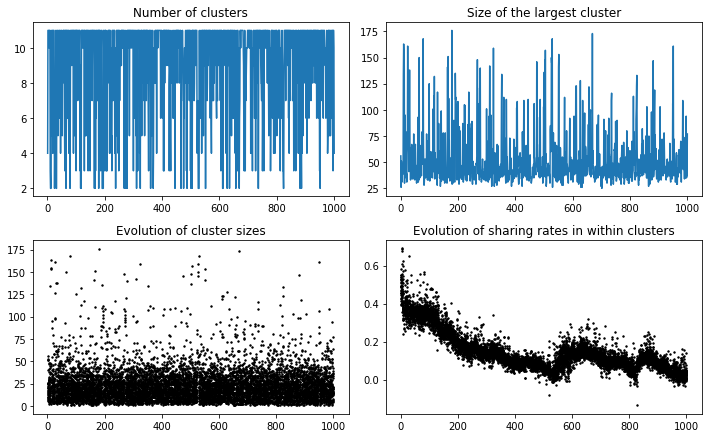

In [42]:
sim = Sim_mutant_resident(n_iter = 1000, n_res = 100, p_coop = 0.7, q = 0.4, n_mut = 100, beta=0.5, gamma = 50, alpha = 50, normalise = False)
loc_c, loc_d = sim.plot_results(selection = True, steps = 1, mutation_sharing = True)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=300, blit=True)
rc('animation', html='html5')
anim